In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg


# testing code blocks -----

In [2]:
import torch
import torch.nn as nn

In [29]:
crossentropy = nn.CrossEntropyLoss()
t = torch.rand(97,600)
t_in = torch.ones(1000,600)

In [4]:
crossentropy(t,t)

tensor(1876.8459)

In [5]:

crossentropy = nn.CrossEntropyLoss()

# takes 4 bit onehot encoding
def split_crossentropy(input,target): 

    # apply cross entropy to each 4 bit separately
    hold_losses = crossentropy(input[:,0:4], target[:,0:4]).item() 
    
    for i in range(int(len(input[0])/4) - 1):
        hold_losses = hold_losses + crossentropy(input[:,(i+1)*4:(i+2)*4], target[:,(i+1)*4:(i+2)*4]).item()
    
    return torch.tensor( hold_losses/(len(input[0])/4) , requires_grad=True) # return the average


In [6]:
print(crossentropy(t,t))
print(split_crossentropy(t,t))

tensor(1876.8459)
tensor(2.5780, requires_grad=True)


In [30]:
# testing how to do train/val split
print(t.size())
print(t_in.size())

torch.Size([97, 600])
torch.Size([1000, 600])


# -----

Notes
- input: only sequence rep yeilded sort-of-decent results. probably because the flattening process of token rep led to each residue embedding starting at a different location.
- target: generally methylation motif pad middle did better but it not clear by how much...
- lrval of 0.0001 generally works best
- hidden layers don't really matter as much as long as they are > 1

Questions
- b_loss vs e_loss. Why does the epoch curve look good but the batch "curve" look awful. Is that normal?
- why does my split function not work? It should return values just fine?

Post use_softmax test
- I should NOT use softmax activation. Other activations should be tested in the future...
- 0.0001 continue to be the best for MSE
- Hid 2-5 seem to be best
- No split crossent or split mse. the glitch is still present.



In [13]:
def run_to_dict(dirname):
    run_dict = {}
    f = open(dirname + "/setup.log", "r")
    run_dict = {}
    for line in f:
        if line[0:2] == "--":
            run_dict[line.split(":")[0][2:]] = line.split(":")[1][:-1] #epochs connections hid lrval type batch input_path target_path lf
    if not "use_softmax" in run_dict: run_dict['use_softmax'] = "NA"
    if not "rungroup" in run_dict: run_dict['rungroup'] = "NA"
    
    run_dict['e_loss'] = [float(x) for x in open(dirname + "/epochloss.txt", "r").read().strip('][').split(', ') ]
    run_dict['b_loss'] = [float(x) for x in open(dirname + "/loss.txt", "r").read().strip('][').split(', ') ]

    try:
        run_dict['ev_loss'] = [float(x) for x in open(dirname + "/evalidloss.txt", "r").read().strip('][').split(', ') ]
        run_dict['bv_loss'] = [float(x) for x in open(dirname + "/validloss.txt", "r").read().strip('][').split(', ') ]
    except:
        run_dict['ev_loss'] = "NA"
        run_dict['bv_loss'] = "NA"
    return run_dict


In [15]:
# /runs/groupdir/dir/data.
all_run_dict = {}
for groupdir in os.listdir():
    if os.path.isdir(groupdir) and groupdir != "old":
        all_run_dict[groupdir] = {}
        for dir in os.listdir(groupdir):
            if os.path.isdir(groupdir+"/"+dir):
                all_run_dict[groupdir][dir] = run_to_dict(groupdir+"/"+dir)

# long run no softmax - test layers

In [16]:
all_run_dict.keys()

dict_keys(['TestlossfunTesthid', 'train-validation_first_attempt', 'no_softmax', 'VeryLongRun_nosoftmax_nosplit', '.ipynb_checkpoints'])

In [17]:
all_run_dict['train-validation_first_attempt'].keys()

dict_keys(['11_15_15_30_11_216688', '11_15_15_33_28_426516', '11_15_15_27_49_835685', '11_15_15_31_38_944331', '11_15_15_29_16_663331', '11_15_15_32_39_972805', '11_15_15_34_18_261834', '11_15_15_28_37_758510', '11_15_15_30_54_450982'])

In [18]:
all_run_dict['train-validation_first_attempt']['11_15_15_30_11_216688'].keys()

dict_keys(['epochs', 'connections', 'hid', 'lrval', 'batch', 'input_path', 'target_path', 'lf', 'rungroup', 'train_x_size', 'train_y_size', 'use_softmax', 'e_loss', 'b_loss', 'ev_loss', 'bv_loss'])

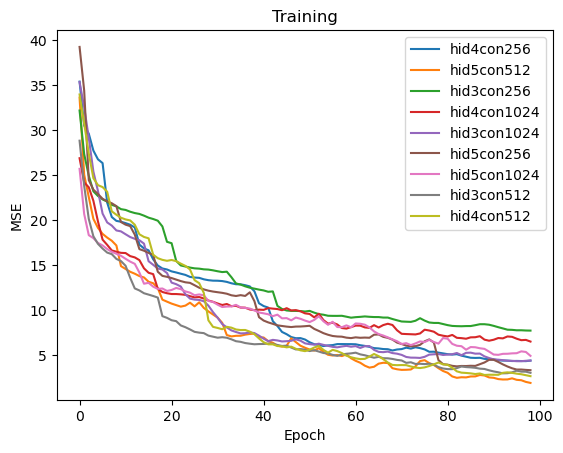

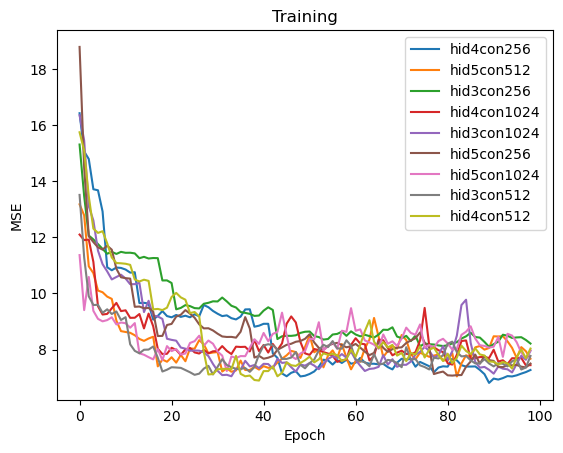

In [28]:
group = 'train-validation_first_attempt'
for run in all_run_dict[group]:
    plt.plot(all_run_dict[group][run]['e_loss'], label="hid"+all_run_dict[group][run]['hid']+"con"+all_run_dict[group][run]['connections'])

plt.legend()
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

for run in all_run_dict[group]:
    plt.plot(all_run_dict[group][run]['ev_loss'], label="hid"+all_run_dict[group][run]['hid']+"con"+all_run_dict[group][run]['connections'])

plt.legend()
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()


In [ ]:
#

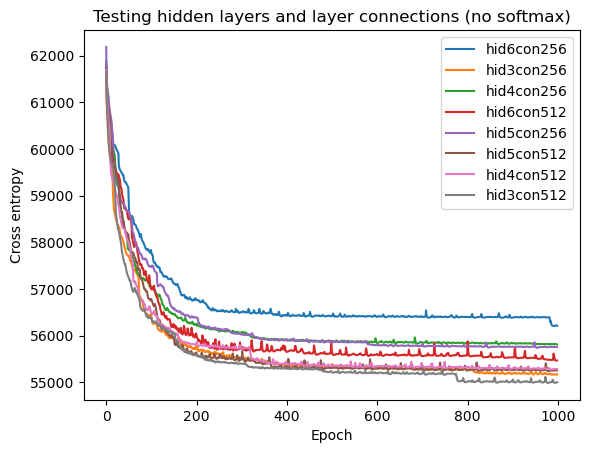

In [32]:
for run in all_run_dict:
    if all_run_dict[run]['rungroup'] == "VeryLongRun_nosoftmax_nosplit" and all_run_dict[run]['lf'] == "crossent":
        plt.plot(all_run_dict[run]['e_loss'], label="hid"+all_run_dict[run]['hid']+"con"+all_run_dict[run]['connections'])
plt.legend()
plt.title('Testing hidden layers and layer connections (no softmax)')
#plt.ylim(35,37)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
plt.show()

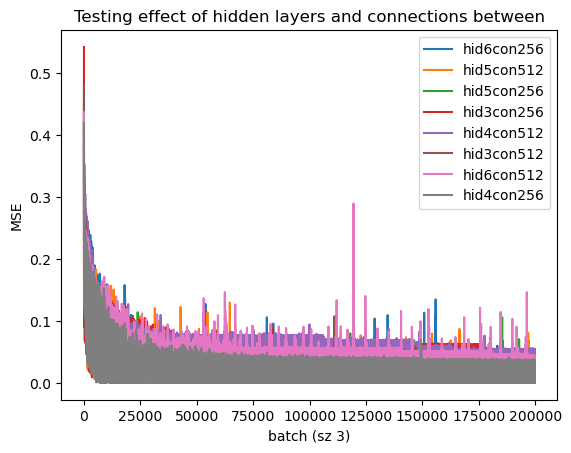

In [33]:
for run in all_run_dict:
    if all_run_dict[run]['rungroup'] == "VeryLongRun_nosoftmax_nosplit" and all_run_dict[run]['lf'] == "mse":
        plt.plot(all_run_dict[run]['b_loss'], label="hid"+all_run_dict[run]['hid']+"con"+all_run_dict[run]['connections'])
plt.legend()
plt.title('Testing effect of hidden layers and connections between')
plt.xlabel('batch (sz 3)')
plt.ylabel('MSE')
plt.show()

# use_softmax

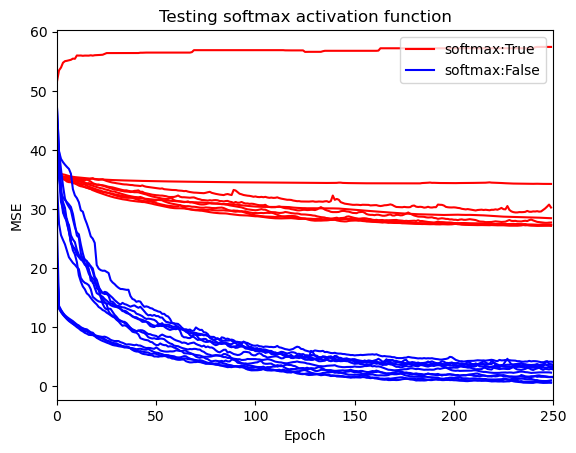

In [34]:
a = True
b= True
for run in all_run_dict:
    if all_run_dict[run]['lf'] == "mse" and float(all_run_dict[run]['lrval']) == 0.0001:
        if all_run_dict[run]['use_softmax'] == "True":
            c = "red"
            if a:
                plt.plot(all_run_dict[run]['e_loss'], label="softmax:"+all_run_dict[run]['use_softmax'], color=c)
                a = False
            else:
                plt.plot(all_run_dict[run]['e_loss'], color=c)
        else:
            c = "blue"
            if b:
                plt.plot(all_run_dict[run]['e_loss'], label="softmax:"+all_run_dict[run]['use_softmax'], color=c)
                b = False
            else:
                plt.plot(all_run_dict[run]['e_loss'], color=c)
        
plt.legend()
plt.title('Testing softmax activation function')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xlim(0,250)
plt.show()

# MSE that succeeded

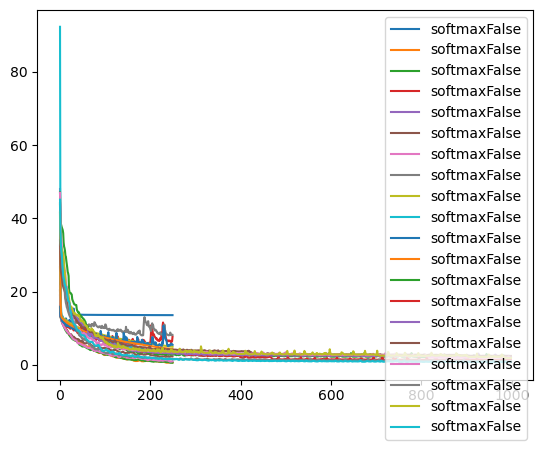

In [35]:
# all mse
for run in all_run_dict:
    if all_run_dict[run]['lf'] == "mse":
        if all_run_dict[run]['e_loss'][-1] > 55:
            #print('failed', "lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'])#print('failed',run)
            pass
        elif all_run_dict[run]['e_loss'][-1] > 20:
            #print('Flattened',  "lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'])
            pass
        else:
            plt.plot(all_run_dict[run]['e_loss'], label="softmax"+all_run_dict[run]['use_softmax'])
plt.legend()
#plt.ylim(35,37)
plt.show()

# CROSSENT that succeeded

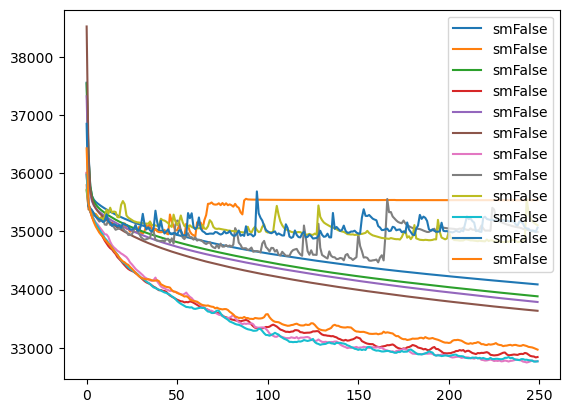

In [36]:
# all mse
for run in all_run_dict:
    if all_run_dict[run]['lf'] == "crossent":
        if all_run_dict[run]['e_loss'][-1] > 38250:
            #print('failed', "lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'])#print('failed',run)
            pass
        elif all_run_dict[run]['e_loss'][-1] > 36000:
            #print('Flattened',  "lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'])
            pass
        else:
            plt.plot(all_run_dict[run]['e_loss'], label="sm"+all_run_dict[run]['use_softmax'])
plt.legend()
#plt.ylim(35,37)
plt.show()

# SPLIT MSE

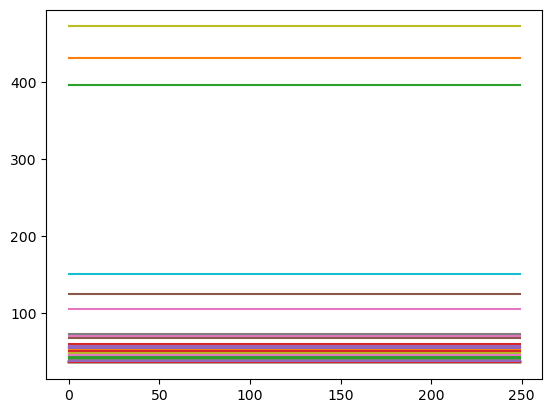

In [37]:
# all mse
for run in all_run_dict:
    if all_run_dict[run]['lf'] == "split_mse":
        plt.plot(all_run_dict[run]['e_loss'], label="hid"+all_run_dict[run]['hid'])
        #if all_run_dict[run]['e_loss'][-1] > 55: print('failed', "lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'],"con",all_run_dict[run]['connections'])#print('failed',run)
#plt.legend()
#plt.ylim(35,37)
plt.show()

# SPLIT CROSSENT

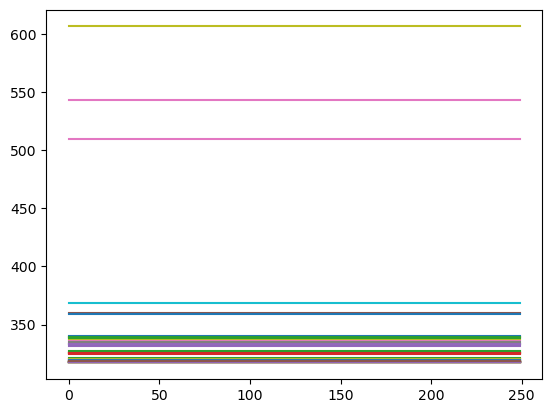

In [38]:
# all mse
for run in all_run_dict:
    if all_run_dict[run]['lf'] == "split_crossent":
        plt.plot(all_run_dict[run]['e_loss'], label="hid"+all_run_dict[run]['hid'])
        #if all_run_dict[run]['e_loss'][-1] > 55: print('failed', "lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'],"con",all_run_dict[run]['connections'])#print('failed',run)
#plt.legend()
#plt.ylim(35,37)
plt.show()

# all

In [39]:
'''
for run in all_run_dict:
    if True:#all_run_dict[run]['lf'] == "mse":
        print("lf",all_run_dict[run]['lf'],"hid",all_run_dict[run]['hid'],"con",all_run_dict[run]['connections'])
        plt.plot(all_run_dict[run]['e_loss'])
        plt.show()
'''

'\nfor run in all_run_dict:\n    if True:#all_run_dict[run][\'lf\'] == "mse":\n        print("lf",all_run_dict[run][\'lf\'],"hid",all_run_dict[run][\'hid\'],"con",all_run_dict[run][\'connections\'])\n        plt.plot(all_run_dict[run][\'e_loss\'])\n        plt.show()\n'